# Análise do PIB de países com Graph Neural Networks (GNN) Classification

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx


import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import KBinsDiscretizer
import plotly.express as px


import seaborn as sns


O objetivo do presente trabalho é prever o PIB (ou GDP) per capita de países com base em uma rede, considerando tanto as informações de determinado país quanto as de seus vizinhos. Para isso, faremos uma regressão e utilizaremos a ferramenta GNN - Graph Neural Network.

## Preparando os dados

### Carregando o dataset com os países vizinhos

Dataset que contém as fronteiras de cada país:

In [2]:
json_file_path = "nodes_and_links_countries.json"

with open(json_file_path, 'r') as j:
     jdict = json.loads(j.read())

### Carregando o dataset com os dados dos países

Dataset que contém as informações de cada país:

In [3]:
path = "countries of the world.csv"
df_gdp = pd.read_csv(path,decimal=',')
df_gdp.head().T

,0,1,2,3,4
Country,Afghanistan,Albania,Algeria,American Samoa,Andorra
Region,ASIA (EX. NEAR EAST),EASTERN EUROPE,NORTHERN AFRICA,OCEANIA,WESTERN EUROPE
Population,31056997,3581655,32930091,57794,71201
Area (sq. mi.),647500,28748,2381740,199,468
Pop. Density (per sq. mi.),48,124.6,13.8,290.4,152.1
Coastline (coast/area ratio),0,1.26,0.04,58.29,0
Net migration,23.06,-4.93,-0.39,-20.71,6.6
Infant mortality (per 1000 births),163.07,21.52,31,9.27,4.05
GDP ($ per capita),700,4500,6000,8000,19000
Literacy (%),36,86.5,70,97,100


In [4]:
### Removendo espaços ao final do nome dos países
df_gdp['Country'] = df_gdp['Country'].map(lambda x: str(x)[:-1])

### Alterando nomes de países para combinar os datasets

In [5]:
correspondence = {
   'Micronesia, Fed. St.':'Federated States of Micronesia',
   'Antigua & Barbuda':'Antigua and Barbuda',
   'Bahamas, The':'Bahamas',
   'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
   'Trinidad & Tobago':'Trinidad and Tobago',
   'Central African Rep.': 'Central African Republic',
   'Congo, Dem. Rep.':'Democratic Republic of the Congo',
   'Congo, Repub. of the':'Republic of the Congo',
   "Cote d'Ivoire": "Côte d'Ivoire",
   'Gambia, The': 'The Gambia',
   'Sao Tome & Principe':'São Tomé and Príncipe',
   'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
   'Macedonia':'North Macedonia',
   'China': "People's Republic of China",
   'Korea, North':'North Korea',
   'Korea, South':'South Korea',
   'Burma':'Myanmar'
    }

In [6]:
df_gdp = df_gdp.replace({"Country": correspondence})

In [7]:
countries_df = df_gdp['Country'].values
countries_nodes = ([node['name'] for node in jdict['nodes']])

mismatch = [i for i in countries_nodes if i not in countries_df]

print(
"countries_df: ",len(countries_df),
"countries_nodes: ",len(countries_nodes),
"mismatch: ",len(mismatch),
"mismatch countries:", mismatch
)

countries_df:  227 countries_nodes:  195 mismatch:  4 mismatch countries: ['South Sudan', 'Montenegro', 'Vatican City', 'Palestine']


Parece que alguns países não têm correspondência. Como são bem poucos, podemos removê-los:

In [8]:
nodes = set(countries_nodes)-set(mismatch)
len(nodes)

191

### Dataset com países correspondentes

Vamos deixar somente os países com correspondência nos dois datasets para a análise:

In [9]:
nodes_df = [i for i in nodes]
df = df_gdp[df_gdp['Country'].isin(nodes_df)]
df.head(5).T

,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Region,ASIA (EX. NEAR EAST),EASTERN EUROPE,NORTHERN AFRICA,WESTERN EUROPE,SUB-SAHARAN AFRICA
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),48,124.6,13.8,152.1,9.7
Coastline (coast/area ratio),0,1.26,0.04,0,0.13
Net migration,23.06,-4.93,-0.39,6.6,0
Infant mortality (per 1000 births),163.07,21.52,31,4.05,191.19
GDP ($ per capita),700,4500,6000,19000,1900
Literacy (%),36,86.5,70,100,42


#### Tirando algumas colunas que não serão utilizadas na análise inicial

In [10]:
df.drop(['Region','Climate'], axis=1, inplace=True)
df.head(5).T

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),48,124.6,13.8,152.1,9.7
Coastline (coast/area ratio),0,1.26,0.04,0,0.13
Net migration,23.06,-4.93,-0.39,6.6,0
Infant mortality (per 1000 births),163.07,21.52,31,4.05,191.19
GDP ($ per capita),700,4500,6000,19000,1900
Literacy (%),36,86.5,70,100,42
Phones (per 1000),3.2,71.2,78.1,497.2,7.8


In [11]:
df.isna().sum()

Country                               0
Population                            0
Area (sq. mi.)                        0
Pop. Density (per sq. mi.)            0
Coastline (coast/area ratio)          0
Net migration                         0
Infant mortality (per 1000 births)    0
GDP ($ per capita)                    0
Literacy (%)                          7
Phones (per 1000)                     2
Arable (%)                            0
Crops (%)                             0
Other (%)                             0
Birthrate                             1
Deathrate                             1
Agriculture                           3
Industry                              4
Service                               4
dtype: int64

Como temos poucos valores nulos, podemos removê-los do dataset.

In [12]:
df=df.dropna()   

## Análise exploratória

### Analisando correlações

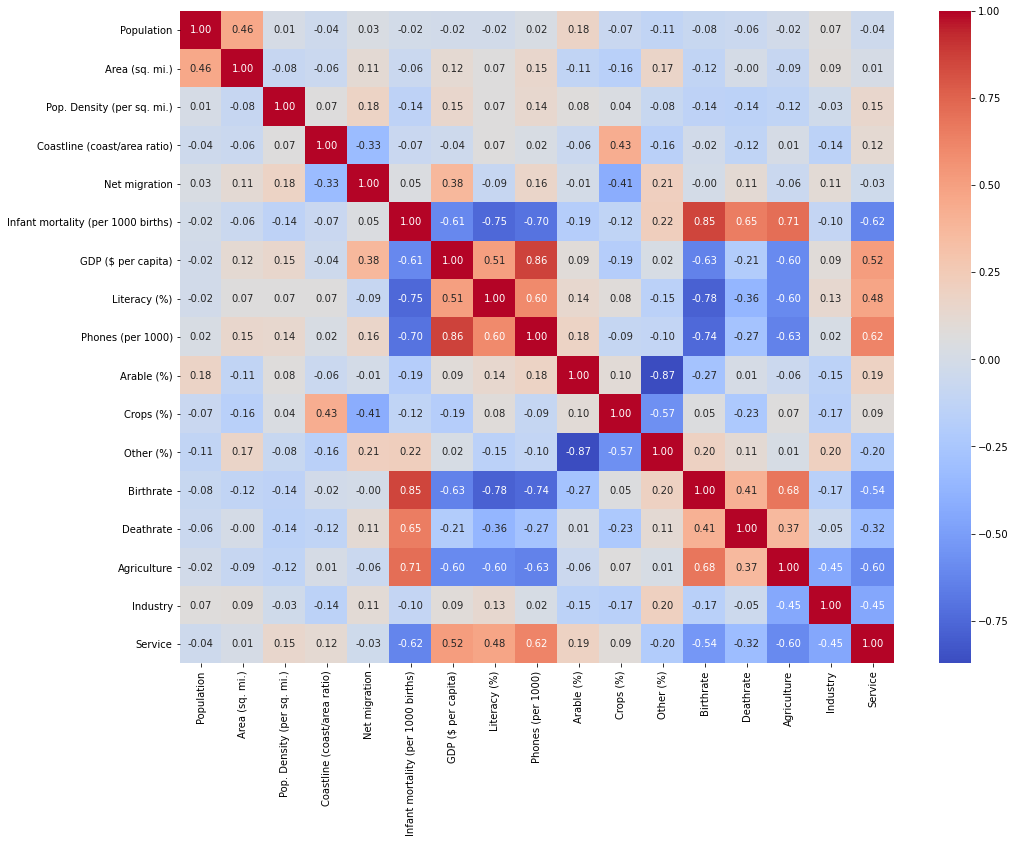

In [13]:
import seaborn as sns

plt.figure(figsize=(16,12))
sns.heatmap(data=df.iloc[:,1:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\User\anaconda3\l

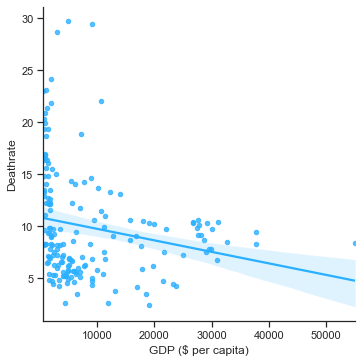

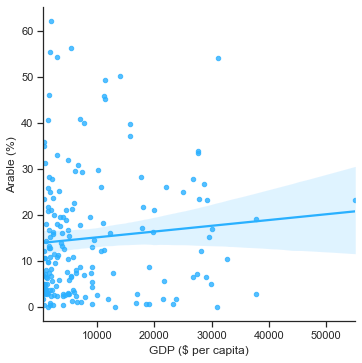

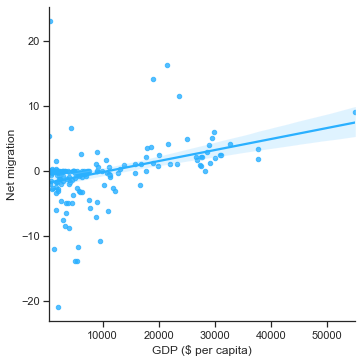

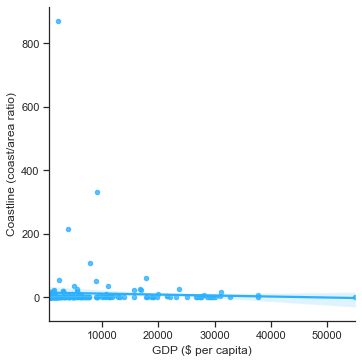

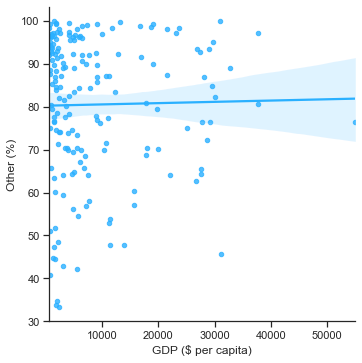

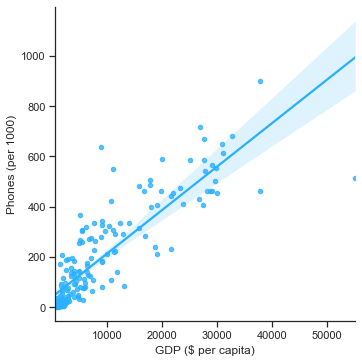

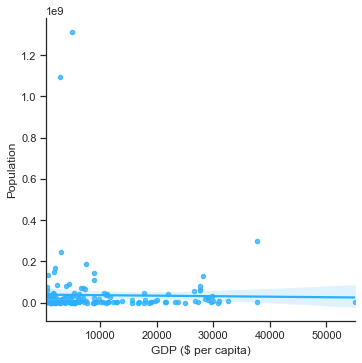

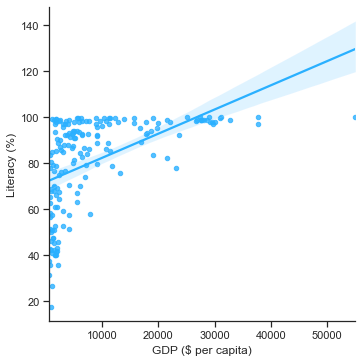

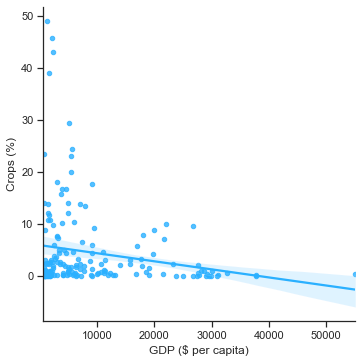

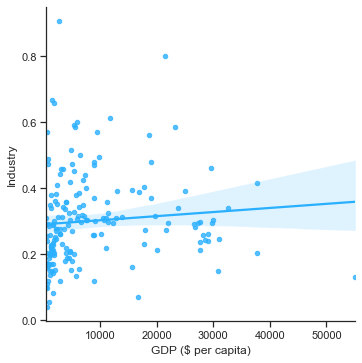

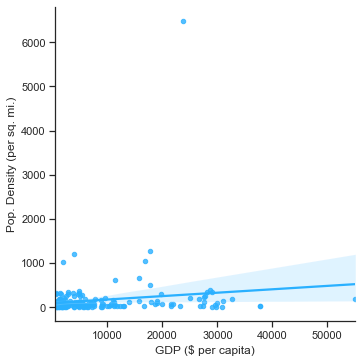

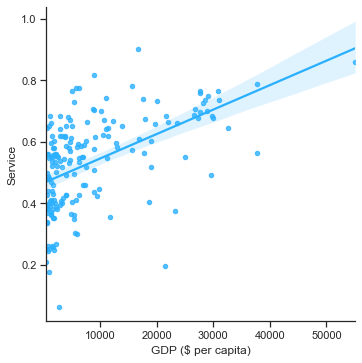

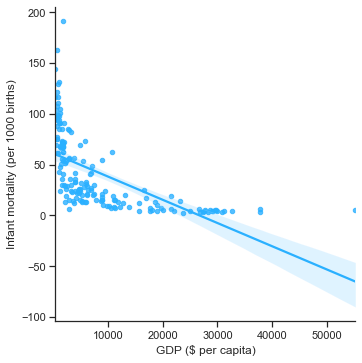

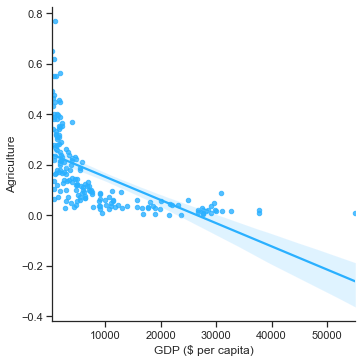

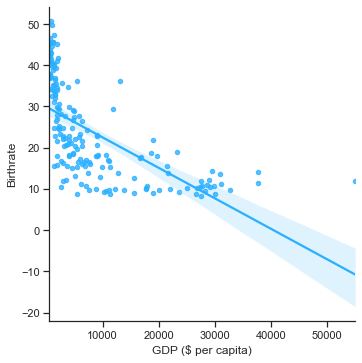

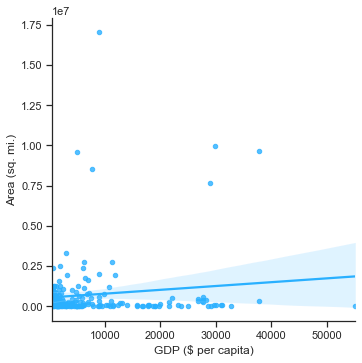

In [14]:
p=['#2ab0ff', 'pink', 'green','purple', 'r', 'b', 'y']
sns.set_theme(style="ticks", palette=p, font_scale=1)

num = set(df.columns.to_list()) - {'Country', 'GDP ($ per capita)', 'Climate'}

for n in num:
    sns.lmplot('GDP ($ per capita)', n, data=df, fit_reg=True, scatter_kws={"marker": "D", "s": 20})

### Distribuição dos dados

array([[<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'Area (sq. mi.)'}>,
        <AxesSubplot:title={'center':'Pop. Density (per sq. mi.)'}>,
        <AxesSubplot:title={'center':'Coastline (coast/area ratio)'}>],
       [<AxesSubplot:title={'center':'Net migration'}>,
        <AxesSubplot:title={'center':'Infant mortality (per 1000 births)'}>,
        <AxesSubplot:title={'center':'GDP ($ per capita)'}>,
        <AxesSubplot:title={'center':'Literacy (%)'}>],
       [<AxesSubplot:title={'center':'Phones (per 1000)'}>,
        <AxesSubplot:title={'center':'Arable (%)'}>,
        <AxesSubplot:title={'center':'Crops (%)'}>,
        <AxesSubplot:title={'center':'Other (%)'}>],
       [<AxesSubplot:title={'center':'Birthrate'}>,
        <AxesSubplot:title={'center':'Deathrate'}>,
        <AxesSubplot:title={'center':'Agriculture'}>,
        <AxesSubplot:title={'center':'Industry'}>],
       [<AxesSubplot:title={'center':'Service'}>, <AxesSubplot:>,
     

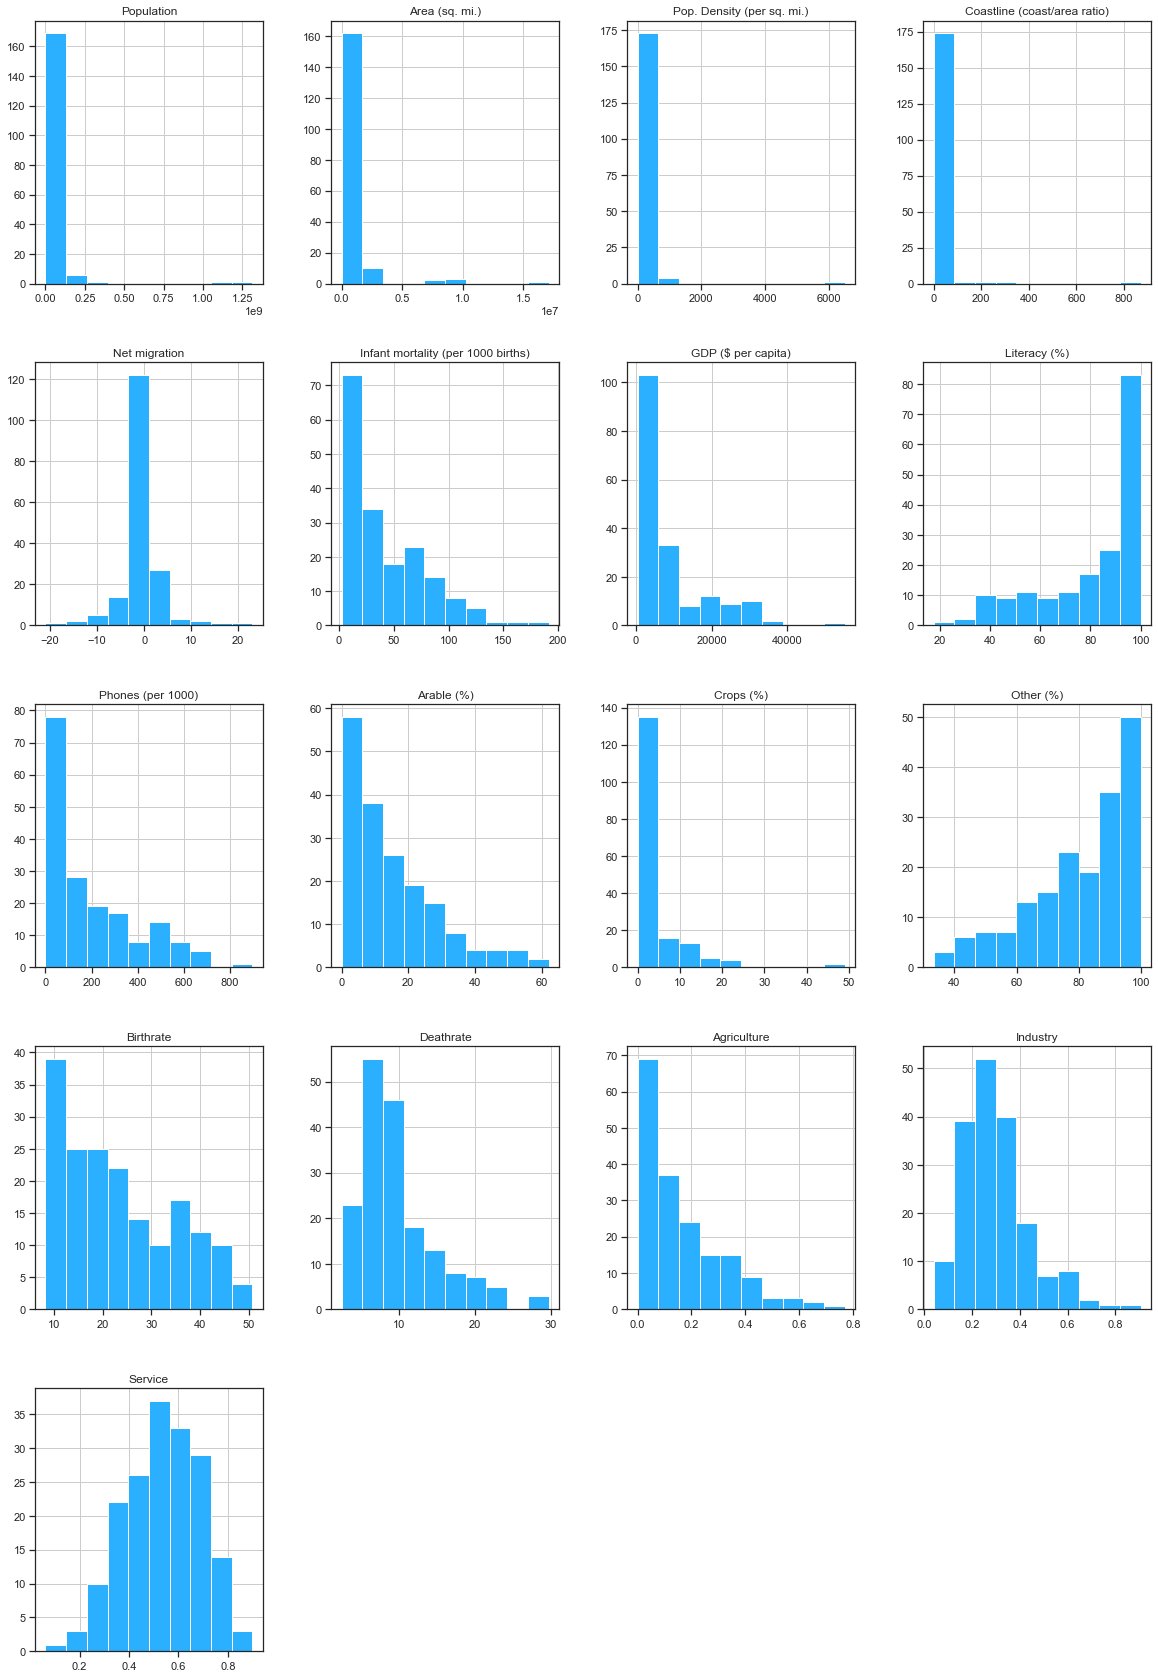

In [15]:
df.hist(figsize=(20,30))

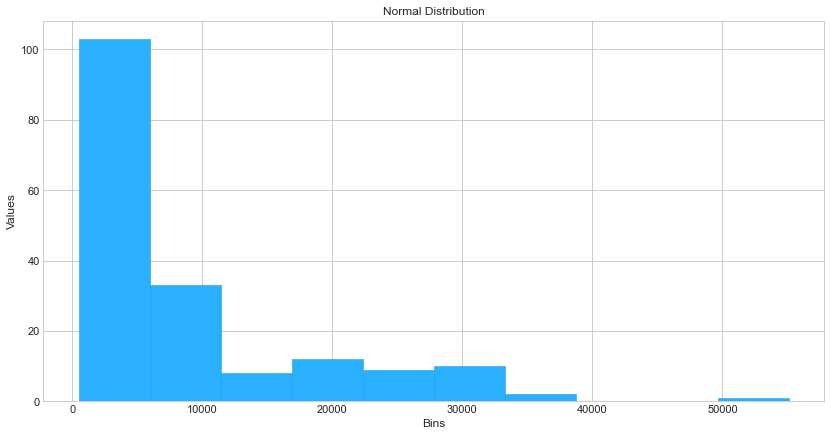

In [16]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(df["GDP ($ per capita)"], facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Normal Distribution') 
plt.xlabel('Bins') 
plt.ylabel('Values') 
plt.show()

<AxesSubplot:xlabel='GDP ($ per capita)'>

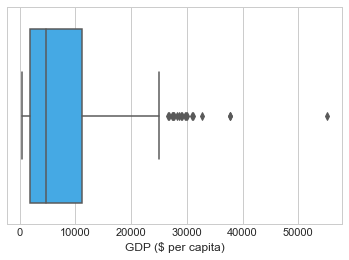

In [17]:
sns.boxplot(data = df, x = "GDP ($ per capita)")

#### Tratando assimetrias

Parece que existe forte assimetria em algumas colunas do dataset. Isso inclui o target, que tem uma forte assimetria a direita, com muitos outliers.
Para casos de assimetria a direita, vamos aplicar log na base 10. Para casos de assimetria a direita, vamos aplicar raiz quadrada.

In [18]:
df_filtered = df.copy()
df_filtered['Infant mortality (per 1000 births)'] = df['Infant mortality (per 1000 births)'].apply(np.log10)
df_filtered['GDP ($ per capita)'] = df['GDP ($ per capita)'].apply(np.log10)
df_filtered['Phones (per 1000)'] = df['Phones (per 1000)'].apply(np.log10)
df_filtered['Population'] = df['Population'].apply(np.log10)
df_filtered['Area (sq. mi.)'] = df['Area (sq. mi.)'].apply(np.log10)
# df_filtered['Agriculture'] = df['Agriculture'].apply(np.log10)
df_filtered['Deathrate'] = df['Deathrate'].apply(np.log10)

# df_filtered['Arable (%)'] = df['Arable (%)'].apply(np.log10)
# df_filtered['Crops (%)'] = df['Crops (%)'].apply(np.log10)
# df_filtered['Coastline (coast/area ratio)'] = df['Coastline (coast/area ratio)'].apply(np.log10)
df_filtered['Pop. Density (per sq. mi.)'] = df['Pop. Density (per sq. mi.)'].apply(np.log10)
df_filtered['Other (%)'] = df['Other (%)'].apply(np.sqrt)
df_filtered['Literacy (%)'] = df['Literacy (%)'].apply(np.sqrt)


In [ ]:
df_filtered.hist(figsize=(20,30))

In [ ]:
p=['pink', 'blue']
sns.set_theme(style="ticks", palette=p, font_scale=1)

sns.boxplot(data = df_filtered, x = "GDP ($ per capita)")
sns.boxplot(x=df_filtered["GDP ($ per capita)"])

Parece que a distribuição do target melhorou bem depois que o log foi aplicado.

## Montagem do grafo

Vamos montar o nosso grafo com as seguintes características:
* Nodes são países
* Node features são as features dos países
* Dois países estão conectados se existe uma fronteira geográfica entre eles

### Criando identificadores únicos para os países

In [ ]:
df_test = df_filtered.copy()

class_values = sorted(df_test["Country"].unique())
print(len(class_values))
class_idx = {name: id for id, name in enumerate(class_values)}
df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])
df_test.head().T

In [ ]:
df_test = df_test.rename({'GDP ($ per capita)': 'GDP'}, axis=1) 
df_test.T

### Garantindo correspondência entre os nomes de países dos datasets

In [ ]:
existing_countries = df_test.Country.to_list()

In [ ]:
edges = []
for n in jdict['links']:
    if (n['source'] in existing_countries) and (n['target'] in existing_countries):
        edges.append((n['source'], n['target']))
df_edges= pd.DataFrame.from_records(edges, columns =['source', 'target'])
df_edges.head(5).T



### Visualizando como um grafo

In [ ]:
G = nx.Graph()
G.add_nodes_from([node['name'] for node in jdict['nodes']])
G.add_weighted_edges_from([(edge['source'], edge['target'], edge['border'])
                  for edge in jdict['links']])

pos = nx.spring_layout(G, k=.6)
plt.figure(figsize=(25,12))
nx.draw(G, 
        pos=pos,
        node_size=800, 
        with_labels=True, 
        node_color='pink')
plt.show()

### Transformando os nodes do grafo em valores numéricos (IDs)

In [ ]:
class_values = sorted(df_test["Country"].unique())
print(len(class_values))
class_idx = {name: id for id, name in enumerate(class_values)}
df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])
df_test.head().T


In [ ]:
df_edges["source"] = df_edges["source"].apply(lambda name: class_idx[name])
df_edges["target"] = df_edges["target"].apply(lambda name: class_idx[name])

In [ ]:
df_edges.head(20).T

# Montando o classificador
Tutorial base: https://keras.io/examples/graph/gnn_citations/


In [ ]:
feature_names = set(df_test.columns) - {"Country", "GDP", 'Country ID'}
num_features = len(feature_names)
num_classes = num_features
print(num_features, num_classes)

### Separando treino e teste

In [ ]:
train_data, test_data = [], []

for _, group_data in df_test.groupby("GDP"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.7
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

In [ ]:
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

y_train = train_data["GDP"]
y_test = test_data["GDP"]

In [ ]:
x_train.shape

### Testando o desempenho de modelos simples

In [ ]:
def model_predict(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    train_pred_Y = model.predict(x_train)
    test_pred_Y = model.predict(x_test)
    train_pred_Y = pd.Series(train_pred_Y.clip(0, train_pred_Y.max()), index=y_train.index)
    test_pred_Y = pd.Series(test_pred_Y.clip(0, test_pred_Y.max()), index=y_test.index)


    rmse_train = np.sqrt(mean_squared_error(train_pred_Y, y_train))
    msle_train = mean_squared_log_error(train_pred_Y, y_train)
    rmse_test = np.sqrt(mean_squared_error(test_pred_Y, y_test))
    msle_test = mean_squared_log_error(test_pred_Y, y_test)

    print('rmse_train:',rmse_train,'msle_train:',msle_train)
    print('rmse_test:',rmse_test,'msle_test:',msle_test)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model = LinearRegression()
model_predict(model, x_train, y_train, x_test, y_test)

In [ ]:
model = RandomForestRegressor(n_estimators = 50,
                             max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)

model_predict(model, x_train, y_train, x_test, y_test)

In [ ]:
feature_importances = (list(zip(model.feature_importances_,feature_names)))

In [ ]:
model = DecisionTreeRegressor(max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)

model_predict(model, x_train, y_train, x_test, y_test)

In [ ]:
sorted(feature_importances, key=lambda x: x[0], reverse=True)

### Testando um modelo baseline 
Vamos primeiramente testar um modelo que ainda não leva em consideração as conexões do grafo. Ou seja, ele tenta prever o GDP apenas com a informação de cada país, desconsiderando suas fronteiras e as informações dos vizinhos.

In [ ]:
##  Feedforward Network (FFN) Module
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])

    outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="baseline")


baseline_model = create_baseline_model( [32, 32], num_classes,  0.5)
baseline_model.summary()


In [ ]:
def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer=keras.optimizers.Adam(1e-1),
        loss='mse',
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="loss", patience=50, restore_best_weights=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=5000,
        batch_size=2048,
        validation_split=0.2,
        callbacks=[early_stopping],

    )

    return history

In [ ]:
def display_learning_curves(history):
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    plt.show()

In [ ]:
history_baseline = run_experiment(baseline_model, x_train, y_train)

In [ ]:
display_learning_curves(history_baseline)

In [ ]:
original_mse = np.sqrt(baseline_model.evaluate(x=x_test, y=y_test, verbose=0))

In [ ]:
original_mse

In [ ]:
list(zip(baseline_model(x_test).numpy()[:,0], y_test))

Parece que encontramos um caso de underfitting, em que o modelo pareceu não aprender com os dados e obteve um desempenho ruim já no próprio treinamento. 

### Modelo GNN - que considera os grafos

Uma Graph neural network (GNN) é uma classe de redes neurais artificiais para processamento de dados que podem ser representados como grafos. O elemento-chave de design das GNNs é o uso da passagem de mensagens em pares, de modo que os nós do grafo atualizem iterativamente suas representações trocando informações com seus vizinhos.

Vamos usá-la para incorporar as informações dos países vizinhos na previsão do nosso modelo. 

Nossa implementação consiste de três métodos principais:

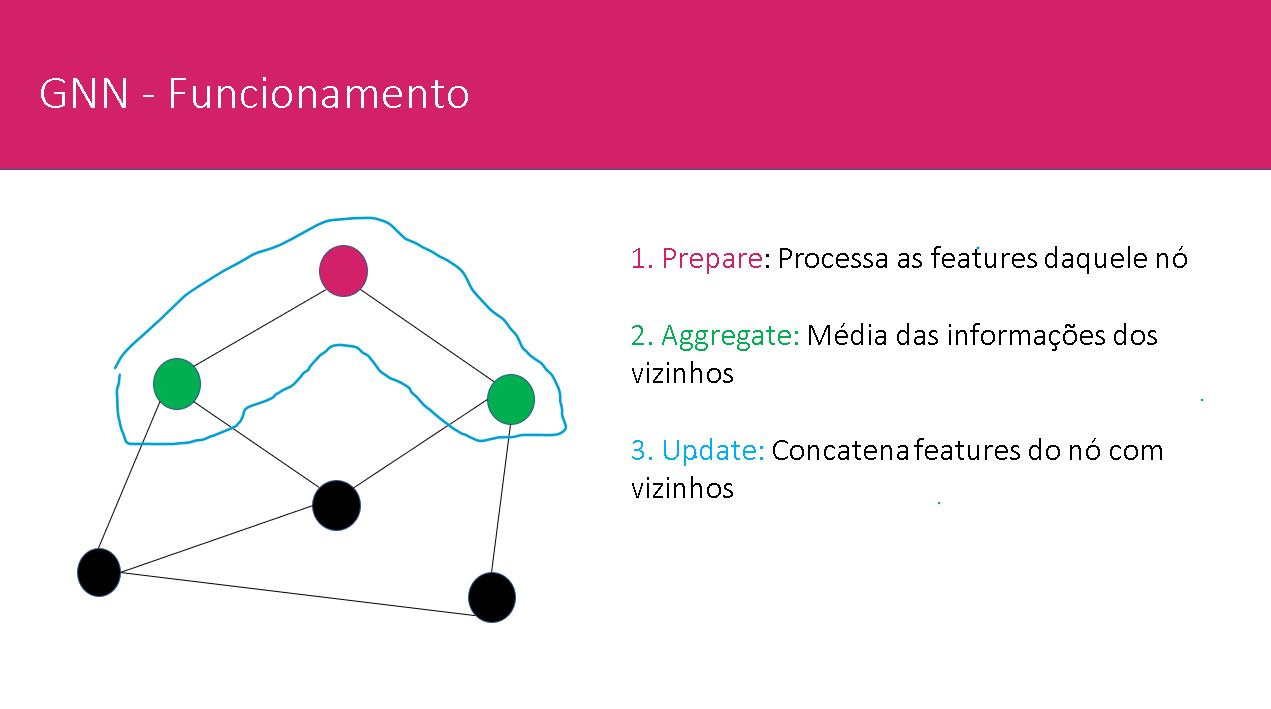

Vamos entender melhor estes três métodos implementados:
1. Prepare: As representações do nó de entrada são processadas usando uma FFN (aquela que definimos anteriormente). Vamos chamar o output desta etapa de mensagens.
2. Aggregate: As mensagens dos vizinhos de cada nó são agregadas em relação aos pesos_de borda usando uma operação de média, para preparar uma única mensagem agregada para cada nó.
3. Update: As node_representations (do próprio nó) e aggregated_messages (dos vizinhos) são concatenadas e processadas para produzir um novo estado das representações do nó. Por fim, essas informações são processadas por uma FFN.

In [ ]:
DROPOUT_RATE  =0.2

In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=DROPOUT_RATE,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[0]
        aggregated_message = tf.math.unsorted_segment_mean(
            neighbour_messages, node_indices, num_segments=num_nodes
        )
        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        node_embeddings = self.update_fn(h)
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        return self.update(node_repesentations, aggregated_messages)


In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=DROPOUT_RATE,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights

        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])

        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")

        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )

        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)


#### Preparação dos dados

Os dados do grafo são representados pela tupla graph_info, que consiste nos seguintes elementos:

* node_features: Array [num_nodes, num_features] que inclui as features do nó. Neste conjunto de dados, os nós são os países e os node_features são as características de cada país.
* edges: Array [num_edges, num_edges]  NumPy representando uma matriz dos links entre os nós. Neste caso, os links existem se os países compartilham uma fronteira.
* edge_weights: Array [num_edges] que inclui os pesos das arestas, que quantificam as relações entre os nós no gráfico. Neste caso, não foram atribuídos pesos diferentes às fronteiras, de modo que todos têm o valor 1.

In [ ]:
edges = df_edges[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    df_test.sort_values("Country")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

In [ ]:
graph_info = (node_features, edges, edge_weights)
print("Node features shape:", node_features.shape)
print("Edges shape:", edges.shape)
print("edge_weights shape:", edge_weights.shape)

#### Instanciando o modelo

In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=[32, 32],
    dropout_rate=DROPOUT_RATE,
    name="gnn_model",
)


In [ ]:
gnn_model([1,10])

In [ ]:
gnn_model.summary()

In [ ]:
x_train = train_data['Country ID'].to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

### Análise de Desempenho

In [ ]:
def display_learning_curves(history):
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

    ax1.plot(history.history["loss"][70:])
    ax1.plot(history.history["val_loss"][70:])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    plt.show()

In [ ]:
display_learning_curves(history)

In [ ]:
x_test = test_data['Country ID'].to_numpy()

#### Performance no treino

In [ ]:
mse_train = gnn_model.evaluate(x=x_train, y=y_train, verbose=0)
print(np.sqrt(mse_train))


#### Performance no teste

In [ ]:
mse_test = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(np.sqrt(mse_test))

#### Melhora comparado ao baseline model

In [ ]:
original_mse/np.sqrt(mse_test)

#### Lista de previsões individuais

In [ ]:
list(zip(x_train, gnn_model(x_train).numpy()[:,0], y_train))

In [ ]:
list(zip(x_train, gnn_model(x_train).numpy()[:,0], y_train))

In [ ]:
list(zip(gnn_model(x_train).numpy()[:,0], y_train))

Parece que este modelo ficou bem melhor! Os valores preditos são bem próximos dos reais